In [ ]:
!pip install wfdb
!pip install pandas numpy matplotlib seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install tqdm
!pip install tensorboard
!pip install scikit-multilearn
!pip install scipy

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from pathlib import Path
from tqdm import tqdm
import wfdb
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.signal import butter, filtfilt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, multilabel_confusion_matrix
from scipy import signal
from scipy.stats import pearsonr
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# directories
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# we saved the data in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
DATASET_PATH = '/content/drive/MyDrive/datathon/ptb-xl/'
CSV_PATH = os.path.join(DATASET_PATH, 'ptbxl_database.csv')
RECORDS_PATH = DATASET_PATH 
NOPY_PATH = './ecg_npy_100'

os.makedirs(NOPY_PATH, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# Convert signal 100Hz to .npy
# This will convert the ECG records to numpy arrays and save them in the specified directory.
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting ECGs"):
    try:
        filename = row['filename_lr']
        ecg_id = str(row['ecg_id']).zfill(5)
        record_path = os.path.join(RECORDS_PATH, filename)

        npy_file = os.path.join(NOPY_PATH, f"{ecg_id}_lr.npy")
        if os.path.exists(npy_file):
            continue 

        record = wfdb.rdrecord(record_path)
        ecg_data = record.p_signal.T 

        np.save(npy_file, ecg_data)

    except Exception as e:
        print(f"Error on {row['ecg_id']}: {e}")


In [ ]:
# Parse scp_codes from string to dictionary
def parse_scp_codes(code_str):
    try:
        return ast.literal_eval(code_str)
    except:
        return {}

df['scp_codes_dict'] = df['scp_codes'].apply(parse_scp_codes)

with open(os.path.join(DATASET_PATH, 'all_labels.pkl'), 'rb') as f:
    all_labels = pickle.load(f)

# Ensure 'strat_fold' exists in the DataFrame, couse it is used for stratified splitting
assert 'strat_fold' in df.columns, "strat_fold not found."
train_df = df[df['strat_fold'].isin(range(1, 9))]
val_df   = df[df['strat_fold'] == 9]
test_df  = df[df['strat_fold'] == 10]

# Function to apply bandpass filter
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=1)

# Custom Dataset for PTB-XL 
class PTBXLDataset(Dataset):
    def __init__(self, dataframe, all_labels, npy_dir, duration=10, sampling_rate=100):
        self.df = dataframe.copy()
        self.all_labels = all_labels
        self.npy_dir = npy_dir
        self.n_samples = duration * sampling_rate
        self.mlb = MultiLabelBinarizer(classes=all_labels)
        self.mlb.fit([all_labels])
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        ecg_id = row.name
        npy_path = os.path.join(self.npy_dir, f"{str(ecg_id).zfill(5)}_lr.npy")

        try:
            signal = np.load(npy_path)
            signal = bandpass_filter(signal, lowcut=0.5, highcut=40, fs=self.sampling_rate)
            signal = self.normalize_signal(signal)

            labels = list(row['scp_codes_dict'].keys()) if row['scp_codes_dict'] else []
            label_vector = self.mlb.transform([labels])[0].astype(np.float32)

            return {
                'signal': torch.tensor(signal, dtype=torch.float32),
                'labels': torch.tensor(label_vector, dtype=torch.float32),
                'record_id': ecg_id
            }

        except Exception as e:
            print(f" Error loading {npy_path}: {e}")
            return {
                'signal': torch.zeros(12, self.n_samples),
                'labels': torch.zeros(len(self.all_labels)),
                'record_id': ecg_id
            }

    def normalize_signal(self, signal):
        norm = np.zeros_like(signal)
        for i in range(signal.shape[0]):
            lead = signal[i]
            mean, std = np.mean(lead), np.std(lead)
            norm[i] = (lead - mean) / std if std > 0 else lead
        return norm

# Split the dataset into train, validation, and test sets
total = len(df)
print(f"Train: {len(train_df)} ({len(train_df)/total*100:.1f}%)")
print(f"Val:   {len(val_df)} ({len(val_df)/total*100:.1f}%)")
print(f"Test:  {len(test_df)} ({len(test_df)/total*100:.1f}%)")
print(f"Total labels: {len(all_labels)}")

batch_size = 32
train_dataset = PTBXLDataset(train_df, all_labels, npy_dir=NOPY_PATH)
val_dataset   = PTBXLDataset(val_df, all_labels, npy_dir=NOPY_PATH)
test_dataset  = PTBXLDataset(test_df, all_labels, npy_dir=NOPY_PATH)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

Train: 17418 (79.9%)
Val:   2183 (10.0%)
Test:  2198 (10.1%)
Total labels: 71


In [ ]:
# Define the model architecture
# this is a multi-branch model that combines rhythm analysis, morphology analysis, and global interpretation of ECG signals.
# Each branch uses a different architecture to extract features relevant to its specific task.
class ResNet1DBlock(nn.Module):
    """1D ResNet block for rhythm analysis"""
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet1D block for rhythm analysis
# This block is used in the RhythmBranch to process 1D ECG signals.
class RhythmBranch(nn.Module):
    """1D ResNet for rhythm analysis"""
    def __init__(self, in_channels=12, base_filters=64):
        super().__init__()

        self.initial_conv = nn.Conv1d(in_channels, base_filters, kernel_size=15, stride=2, padding=7)
        self.initial_bn = nn.BatchNorm1d(base_filters)
        self.initial_pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet blocks
        self.layer1 = self._make_layer(base_filters, base_filters, 2, stride=1)
        self.layer2 = self._make_layer(base_filters, base_filters*2, 2, stride=2)
        self.layer3 = self._make_layer(base_filters*2, base_filters*4, 2, stride=2)
        self.layer4 = self._make_layer(base_filters*4, base_filters*8, 2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.output_size = base_filters * 8

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResNet1DBlock(in_channels, out_channels, stride=stride)]
        for _ in range(1, num_blocks):
            layers.append(ResNet1DBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        x = self.initial_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        return x

# Define the MorphologyBranch and GlobalBranch classes
# These branches use 2D convolutions to analyze local morphology and global ECG patterns, respectively
class MorphologyBranch(nn.Module):
    """2D CNN for local morphology analysis"""
    def __init__(self, base_filters=64):
        super().__init__()

        # 2D convolutions to analyze lead patterns
        self.conv1 = nn.Conv2d(1, base_filters, kernel_size=(3, 7), stride=(1, 2), padding=(1, 3))
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 3), stride=(1, 2), padding=(0, 1))

        self.conv2 = nn.Conv2d(base_filters, base_filters*2, kernel_size=(3, 5), stride=(1, 2), padding=(1, 2))
        self.bn2 = nn.BatchNorm2d(base_filters*2)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 3), stride=(1, 2), padding=(0, 1))

        self.conv3 = nn.Conv2d(base_filters*2, base_filters*4, kernel_size=(3, 5), stride=(1, 2), padding=(1, 2))
        self.bn3 = nn.BatchNorm2d(base_filters*4)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 3), stride=(1, 2), padding=(0, 1))

        self.conv4 = nn.Conv2d(base_filters*4, base_filters*8, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(base_filters*8)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.output_size = base_filters * 8

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

# Define the GlobalBranch class
# This branch uses 2D convolutions to analyze global ECG patterns across all leads.
class GlobalBranch(nn.Module):
    """2D CNN for global ECG interpretation"""
    def __init__(self, base_filters=64):
        super().__init__()

        self.conv1 = nn.Conv2d(1, base_filters, kernel_size=(6, 15), stride=(1, 4), padding=(2, 7))
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 4), stride=(1, 2), padding=(0, 1))

        self.conv2 = nn.Conv2d(base_filters, base_filters*2, kernel_size=(4, 11), stride=(1, 3), padding=(1, 5))
        self.bn2 = nn.BatchNorm2d(base_filters*2)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 4), stride=(1, 2), padding=(0, 1))

        self.conv3 = nn.Conv2d(base_filters*2, base_filters*4, kernel_size=(3, 7), stride=(1, 2), padding=(1, 3))
        self.bn3 = nn.BatchNorm2d(base_filters*4)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 3), stride=(1, 2), padding=(0, 1))

        self.conv4 = nn.Conv2d(base_filters*4, base_filters*8, kernel_size=(2, 5), stride=(1, 2), padding=(0, 2))
        self.bn4 = nn.BatchNorm2d(base_filters*8)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.output_size = base_filters * 8

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        return x

# Define the ClinicalECGClassifier class
# This class combines the three branches (rhythm, morphology, and global) into a single
class ClinicalECGClassifier(nn.Module):
    """Multi-branch ECG model for comprehensive analysis"""
    def __init__(self, num_classes=71, base_filters=64):
        super().__init__()

        self.rhythm_branch = RhythmBranch(base_filters=base_filters)
        self.morphology_branch = MorphologyBranch(base_filters=base_filters)
        self.global_branch = GlobalBranch(base_filters=base_filters)

        total_features = (self.rhythm_branch.output_size +
                         self.morphology_branch.output_size +
                         self.global_branch.output_size)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(total_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Forward pass through all branches

        Args:
            x: ECG signal [batch_size, 12, 1000]

        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = x.size(0)
        rhythm_features = self.rhythm_branch(x)

        x_2d = x.unsqueeze(1)

        morphology_features = self.morphology_branch(x_2d)
        global_features = self.global_branch(x_2d)

        combined_features = torch.cat([
            rhythm_features,
            morphology_features,
            global_features
        ], dim=1)

        logits = self.classifier(combined_features)

        return logits

    def get_branch_features(self, x):
        batch_size = x.size(0)

        rhythm_features = self.rhythm_branch(x)
        x_2d = x.unsqueeze(1)
        morphology_features = self.morphology_branch(x_2d)
        global_features = self.global_branch(x_2d)

        return {
            'rhythm': rhythm_features,
            'morphology': morphology_features,
            'global': global_features
        }

# Initialize the model
model = ClinicalECGClassifier(num_classes=len(all_labels))
model = model.to(device)

test_input = torch.randn(4, 12, 1000).to(device)
with torch.no_grad():
    output = model(test_input)
    branch_features = model.get_branch_features(test_input)

# Print the shapes of the input, output, and branch features
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Rhythm features: {branch_features['rhythm'].shape}")
print(f"Morphology features: {branch_features['morphology'].shape}")
print(f"Global features: {branch_features['global'].shape}")

Creating ECG Multi-Branch Model...
Input shape: torch.Size([4, 12, 1000])
Output shape: torch.Size([4, 71])
Rhythm features: torch.Size([4, 512])
Morphology features: torch.Size([4, 512])
Global features: torch.Size([4, 512])


In [ ]:
# Define the ECGTrainer class
# This class handles the training and validation of the ECG model.
class ECGTrainer:
    def __init__(self, model, train_loader, val_loader, all_labels, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.val_f1s = []
        self.all_labels = all_labels
        self.device = device

        # Loss and optimizer
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=1e-3,
            weight_decay=1e-4
        )

        # Scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',
            factor=0.5,
            patience=5,
            verbose=True
        )

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.val_aucs = []
        self.best_auc = 0.0
        self.best_model_path = '/content/drive/MyDrive/datathon/models/ecg_model.pth'

        # Tensorboard
        self.writer = SummaryWriter('logs/ecg_multibranch')

    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1} - Training')

        for batch_idx, batch in enumerate(pbar):
            signals = batch['signal'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            logits = self.model(signals)
            loss = self.criterion(logits, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            if batch_idx % 10 == 0:
                self.writer.add_scalar('Loss/Train_Step', loss.item(),
                                     epoch * len(self.train_loader) + batch_idx)

        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)

        return avg_loss

    def validate(self, epoch):
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Epoch {epoch+1} - Validation')

            for batch in pbar:
                signals = batch['signal'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass
                logits = self.model(signals)
                loss = self.criterion(logits, labels)

                probs = torch.sigmoid(logits)
                
                all_predictions.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

                total_loss += loss.item()
                num_batches += 1

                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)

        aucs = []
        for i in range(len(self.all_labels)):
            try:
                if len(np.unique(all_labels[:, i])) > 1:
                    auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
                    aucs.append(auc)
            except:
                continue

        macro_auc = np.mean(aucs) if aucs else 0.0

        thresholds = np.arange(0.1, 0.9, 0.1)
        f_scores = []
        for threshold in thresholds:
            pred_binary = (all_predictions > threshold).astype(int)
            f_score = f1_score(all_labels, pred_binary, average='samples', zero_division=0)
            f_scores.append(f_score)

        f_max = max(f_scores) if f_scores else 0.0

        avg_loss = total_loss / num_batches
        self.val_losses.append(avg_loss)
        self.val_aucs.append(macro_auc)
        self.val_f1s.append(f_max)

        return avg_loss, macro_auc, f_max

    def train(self, num_epochs=50, resume=False):
        start_epoch = 0
        if resume and os.path.exists(self.best_model_path):
            start_epoch, self.best_auc, self.train_losses, self.val_losses, self.val_aucs, self.val_f1s = load_checkpoint(
                self.model, self.optimizer, self.scheduler, self.best_model_path, self.device
            )


        for epoch in range(start_epoch, num_epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('='*60)

            train_loss = self.train_epoch(epoch)

            val_loss, val_auc, val_fmax = self.validate(epoch)
            self.writer.add_scalar('F1/Val', val_fmax, epoch)

            self.scheduler.step(val_auc)

            # Log to tensorboard
            self.writer.add_scalar('Loss/Train', train_loss, epoch)
            self.writer.add_scalar('Loss/Val', val_loss, epoch)
            self.writer.add_scalar('AUC/Val', val_auc, epoch)
            self.writer.add_scalar('F-max/Val', val_fmax, epoch)
            self.writer.add_scalar('LR', self.optimizer.param_groups[0]['lr'], epoch)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val AUC: {val_auc:.4f}")
            print(f"Val F-max: {val_fmax:.4f}")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.6f}")

            if val_auc > self.best_auc:
                self.best_auc = val_auc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'best_auc': self.best_auc,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'all_labels': self.all_labels,
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses,
                    'val_aucs': self.val_aucs,
                    'val_f1s': self.val_f1s
                }, self.best_model_path)
                print(f"New best model saved! AUC: {val_auc:.4f}")

        self.writer.close()
        print(f"\n Training completed! Best AUC: {self.best_auc:.4f}")
        return self.best_auc

# Function to evaluate the model on the test set
# This function computes the predictions, branch features, and evaluation metrics on the test set.
def evaluate_model(model, test_loader, all_labels, device):
    model.eval()

    all_predictions = []
    all_labels_true = []
    all_branch_features = {'rhythm': [], 'morphology': [], 'global': []}

    print("Evaluating model on test set...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            signals = batch['signal'].to(device)
            labels = batch['labels'].to(device)

            # Get predictions
            logits = model(signals)
            probs = torch.sigmoid(logits)

            # Get branch features
            branch_features = model.get_branch_features(signals)

            # Store results
            all_predictions.append(probs.cpu().numpy())
            all_labels_true.append(labels.cpu().numpy())

            for branch_name, features in branch_features.items():
                all_branch_features[branch_name].append(features.cpu().numpy())

    # Combine results
    predictions = np.vstack(all_predictions)
    labels_true = np.vstack(all_labels_true)

    for branch_name in all_branch_features:
        all_branch_features[branch_name] = np.vstack(all_branch_features[branch_name])

    # Calculate metrics
    print("\n" + "="*50)
    print("TEST SET EVALUATION RESULTS")
    print("="*50)

    # Overall metrics
    aucs = []
    for i in range(len(all_labels)):
        try:
            if len(np.unique(labels_true[:, i])) > 1:
                auc = roc_auc_score(labels_true[:, i], predictions[:, i])
                aucs.append(auc)
        except:
            continue

    macro_auc = np.mean(aucs) if aucs else 0.0

    # F-max
    thresholds = np.arange(0.1, 0.9, 0.1)
    f_scores = []
    for threshold in thresholds:
        pred_binary = (predictions > threshold).astype(int)
        f_score = f1_score(labels_true, pred_binary, average='samples', zero_division=0)
        f_scores.append(f_score)

    f_max = max(f_scores) if f_scores else 0.0
    best_threshold = thresholds[np.argmax(f_scores)]

    print(f"Macro AUC: {macro_auc:.4f}")
    print(f"F-max: {f_max:.4f} (threshold: {best_threshold:.1f})")
    print(f"Number of labels with valid AUC: {len(aucs)}/{len(all_labels)}")

    return {
        'predictions': predictions,
        'labels_true': labels_true,
        'branch_features': all_branch_features,
        'macro_auc': macro_auc,
        'f_max': f_max,
        'best_threshold': best_threshold,
        'individual_aucs': aucs
    }

# Function to load a checkpoint
# This function loads the model, optimizer, and scheduler states from a saved checkpoint.
def load_checkpoint(model, optimizer, scheduler, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_aucs = checkpoint.get('val_aucs', [])
    val_f1s = checkpoint.get('val_f1s', [])

    print(f"Checkpoint loaded (epoch {checkpoint['epoch']}, AUC: {checkpoint['best_auc']:.4f})")
    return checkpoint['epoch'], checkpoint['best_auc'], train_losses, val_losses, val_aucs, val_f1s

# Initialize trainer
print("Initializing ECG Trainer...")
trainer = ECGTrainer(model, train_loader, val_loader, all_labels, device)

# Train the model from the start or resume from a checkpoint
resume = False

# Start training
print("Starting ECG Multi-Branch Model Training...")
print(f"- Labels: {len(all_labels)} classes")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")

Initializing ECG Trainer...
Starting ECG Multi-Branch Model Training...
- Labels: 71 classes
- Training samples: 17418
- Validation samples: 2183


In [ ]:
# Train the model
num_epochs = 25
best_auc = trainer.train(num_epochs=num_epochs, resume=False) #False to retraining

print(f"\nTraining completed with best AUC: {best_auc:.4f}")

In [10]:
checkpoint = torch.load(trainer.best_model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
test_results = evaluate_model(model, test_loader, all_labels, device)

Evaluating model on test set...


Testing: 100%|██████████| 69/69 [07:51<00:00,  6.83s/it]



TEST SET EVALUATION RESULTS
Macro AUC: 0.9424
F-max: 0.7573 (threshold: 0.3)
Number of labels with valid AUC: 71/71



Analyzing branch contributions...


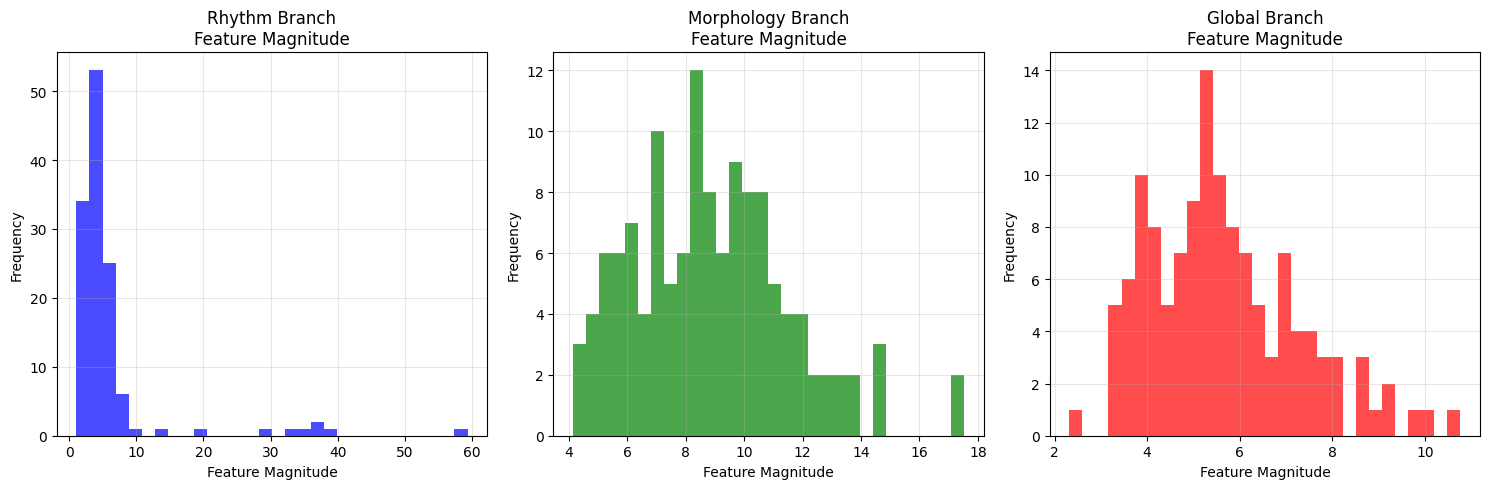


SAMPLE PREDICTION ANALYSIS WITH ECG VISUALIZATION

Sample 1:
----------------------------------------
TRUE LABELS:
  NORM
  SR

TOP 5 PREDICTED:
  ✅ NORM: 0.985
  ✅ SR: 0.953
  ❌ ABQRS: 0.040
  ❌ IVCD: 0.017
  ❌ SBRAD: 0.009

BRANCH FEATURE MAGNITUDES:
  Rhythm: 6.69
  Morphology: 9.02
  Global: 5.28

Sample 2:
----------------------------------------
TRUE LABELS:
  NORM
  SR

TOP 5 PREDICTED:
  ✅ SR: 0.998
  ✅ NORM: 0.982
  ❌ ABQRS: 0.025
  ❌ IVCD: 0.009
  ❌ LMI: 0.005

BRANCH FEATURE MAGNITUDES:
  Rhythm: 4.38
  Morphology: 9.98
  Global: 6.42

Sample 3:
----------------------------------------
TRUE LABELS:
  NORM
  SR

TOP 5 PREDICTED:
  ✅ SR: 0.975
  ✅ NORM: 0.946
  ❌ SVARR: 0.064
  ❌ ABQRS: 0.025
  ❌ 1AVB: 0.013

BRANCH FEATURE MAGNITUDES:
  Rhythm: 4.37
  Morphology: 8.57
  Global: 5.32


In [ ]:
def analyze_sample_predictions_with_ecg(model, test_dataset, all_labels, device, num_samples=3):
    model.eval()

    print(f"\n{'='*80}")
    print("SAMPLE PREDICTION ANALYSIS WITH ECG VISUALIZATION")
    print('='*80)

    for i in range(num_samples):
        sample = test_dataset[i]
        signal = sample['signal'].unsqueeze(0).to(device)
        true_labels = sample['labels'].numpy()

        with torch.no_grad():
            logits = model(signal)
            probs = torch.sigmoid(logits).cpu().numpy()[0]
            branch_features = model.get_branch_features(signal)

        # Find top predicted and true labels
        top_pred_indices = np.argsort(probs)[-5:][::-1]
        true_indices = np.where(true_labels > 0.5)[0]

        print(f"\nSample {i+1}:")
        print("-" * 40)
        print("TRUE LABELS:")
        if len(true_indices) > 0:
            for idx in true_indices:
                print(f"  {all_labels[idx]}")
        else:
            print("  No labels")

        print("\nTOP 5 PREDICTED:")
        for idx in top_pred_indices:
            marker = "✅" if idx in true_indices else "❌"
            print(f"  {marker} {all_labels[idx]}: {probs[idx]:.3f}")

        print(f"\nBRANCH FEATURE MAGNITUDES:")
        for branch_name, features in branch_features.items():
            magnitude = torch.norm(features).item()
            print(f"  {branch_name.capitalize()}: {magnitude:.2f}")

def branch_contributions(model, test_loader, device, num_samples=100):
    model.eval()

    branch_contributions = {'rhythm': [], 'morphology': [], 'global': []}
    all_predictions = []

    with torch.no_grad():
        samples_processed = 0
        for batch in test_loader:
            if samples_processed >= num_samples:
                break

            signals = batch['signal'].to(device)

            full_logits = model(signals)
            full_probs = torch.sigmoid(full_logits)
            branch_features = model.get_branch_features(signals)

            # Analyze each branch contribution (simplified)
            for i, branch_name in enumerate(['rhythm', 'morphology', 'global']):
                feature_magnitude = torch.norm(branch_features[branch_name], dim=1)
                branch_contributions[branch_name].extend(feature_magnitude.cpu().numpy())

            all_predictions.extend(full_probs.cpu().numpy())
            samples_processed += signals.size(0)

    return branch_contributions, all_predictions

print("\nAnalyzing branch contributions...")
branch_contrib, _ = branch_contributions(model, test_loader, device)

# Visualize branch contributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (branch_name, contributions) in enumerate(branch_contrib.items()):
    axes[i].hist(contributions, bins=30, alpha=0.7, color=['blue', 'green', 'red'][i])
    axes[i].set_title(f'{branch_name.capitalize()} Branch\nFeature Magnitude')
    axes[i].set_xlabel('Feature Magnitude')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/branch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

analyze_sample_predictions_with_ecg(model, test_dataset, all_labels, device)

In [12]:
def analyze_feature_importance(model, test_loader, device, num_batches=5):
    model.eval()

    branch_activations = {'rhythm': [], 'morphology': [], 'global': []}
    predictions = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_batches:
                break

            signals = batch['signal'].to(device)

            logits = model(signals)
            probs = torch.sigmoid(logits)

            branch_features = model.get_branch_features(signals)
            for branch_name, features in branch_features.items():
                branch_activations[branch_name].append(features.cpu().numpy())

            predictions.append(probs.cpu().numpy())

    for branch_name in branch_activations:
        branch_activations[branch_name] = np.vstack(branch_activations[branch_name])

    predictions = np.vstack(predictions)

    print(f"\n{'='*60}")
    print("BRANCH IMPORTANCE ANALYSIS")
    print('='*60)

    for branch_name, activations in branch_activations.items():
        avg_activation = np.mean(np.linalg.norm(activations, axis=1))
        high_conf_mask = np.max(predictions, axis=1) > 0.7
        if np.sum(high_conf_mask) > 0:
            high_conf_activations = activations[high_conf_mask]
            avg_high_conf = np.mean(np.linalg.norm(high_conf_activations, axis=1))
        else:
            avg_high_conf = avg_activation

        print(f"{branch_name.capitalize()} Branch:")
        print(f"  Average activation magnitude: {avg_activation:.2f}")
        print(f"  High-confidence activation: {avg_high_conf:.2f}")
        print(f"  Confidence boost ratio: {avg_high_conf/avg_activation:.2f}")

analyze_feature_importance(model, test_loader, device)



BRANCH IMPORTANCE ANALYSIS
Rhythm Branch:
  Average activation magnitude: 6.07
  High-confidence activation: 6.22
  Confidence boost ratio: 1.03
Morphology Branch:
  Average activation magnitude: 8.84
  High-confidence activation: 8.93
  Confidence boost ratio: 1.01
Global Branch:
  Average activation magnitude: 5.71
  High-confidence activation: 5.76
  Confidence boost ratio: 1.01


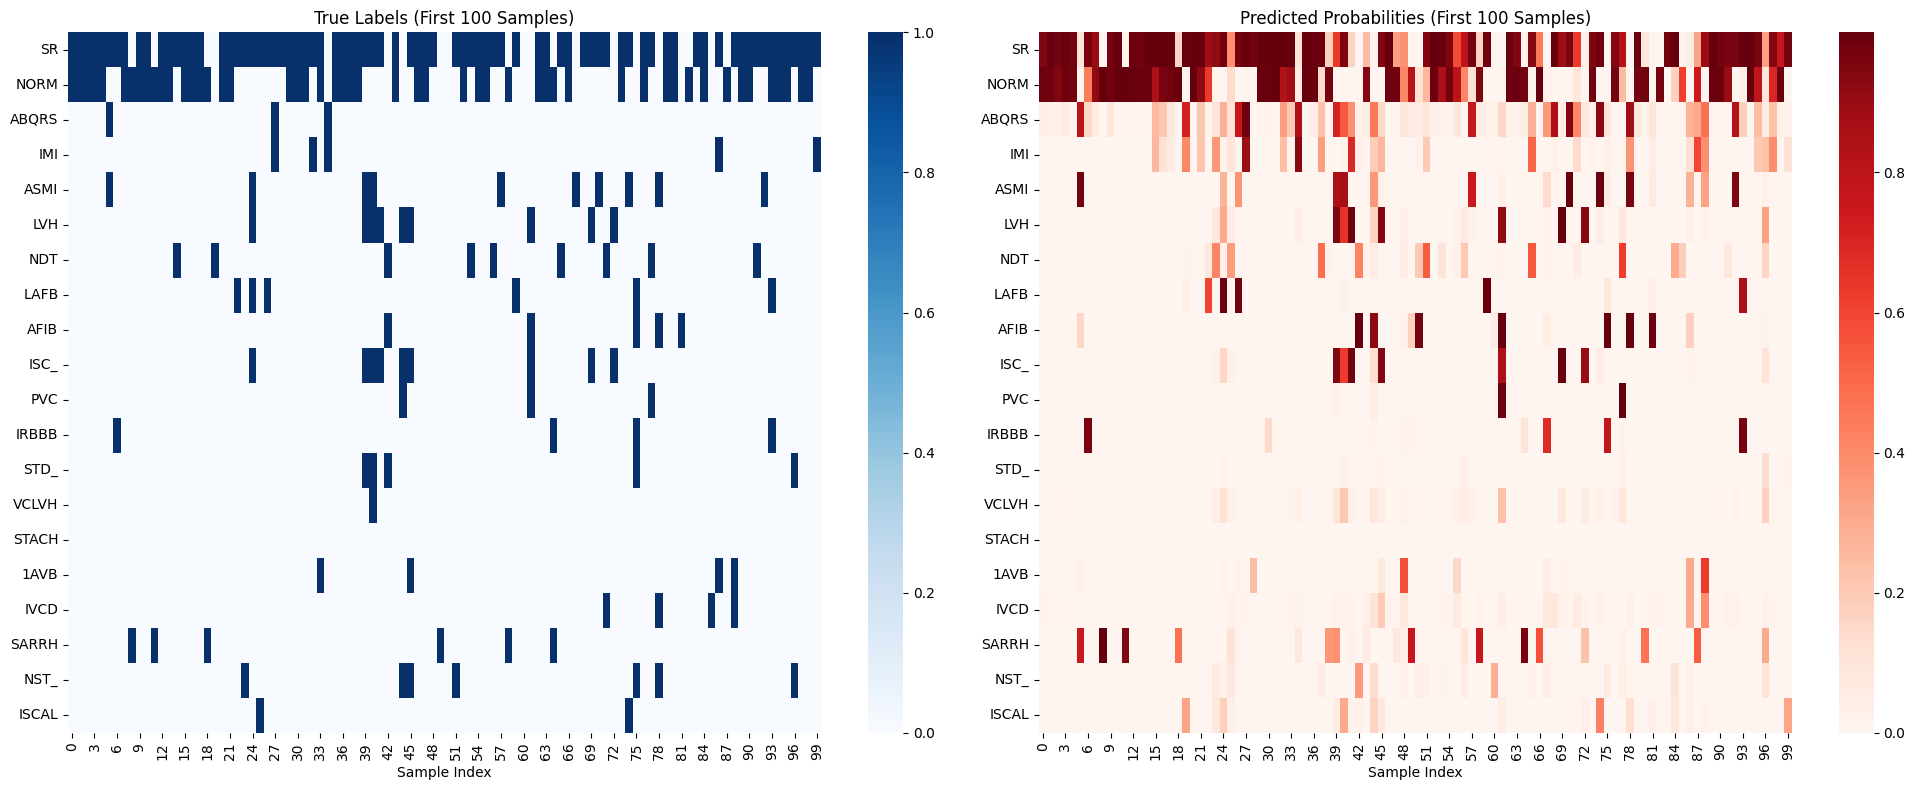

In [ ]:
# Function to visualize predictions and true labels as heatmaps
def prediction_heatmap(predictions, labels_true, all_labels, top_k=20):
    label_counts = labels_true.sum(axis=0)
    top_label_indices = np.argsort(label_counts)[-top_k:][::-1]
    pred_subset = predictions[:100, top_label_indices]
    true_subset = labels_true[:100, top_label_indices]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(true_subset.T, ax=ax1, cmap='Blues', cbar=True,
                yticklabels=[all_labels[i] for i in top_label_indices])
    ax1.set_title('True Labels (First 100 Samples)')
    ax1.set_xlabel('Sample Index')

    sns.heatmap(pred_subset.T, ax=ax2, cmap='Reds', cbar=True,
                yticklabels=[all_labels[i] for i in top_label_indices])
    ax2.set_title('Predicted Probabilities (First 100 Samples)')
    ax2.set_xlabel('Sample Index')

    plt.tight_layout()
    plt.savefig('models/prediction_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

prediction_heatmap(test_results['predictions'],
                         test_results['labels_true'],
                         all_labels, top_k=20)


 TESTING WITH SAMPLE ECG...
Raw signal range: -2.15 to 5.67
True labels:
  ['ABQRS', 'AFIB', 'ASMI', 'ILMI', 'LAFB']


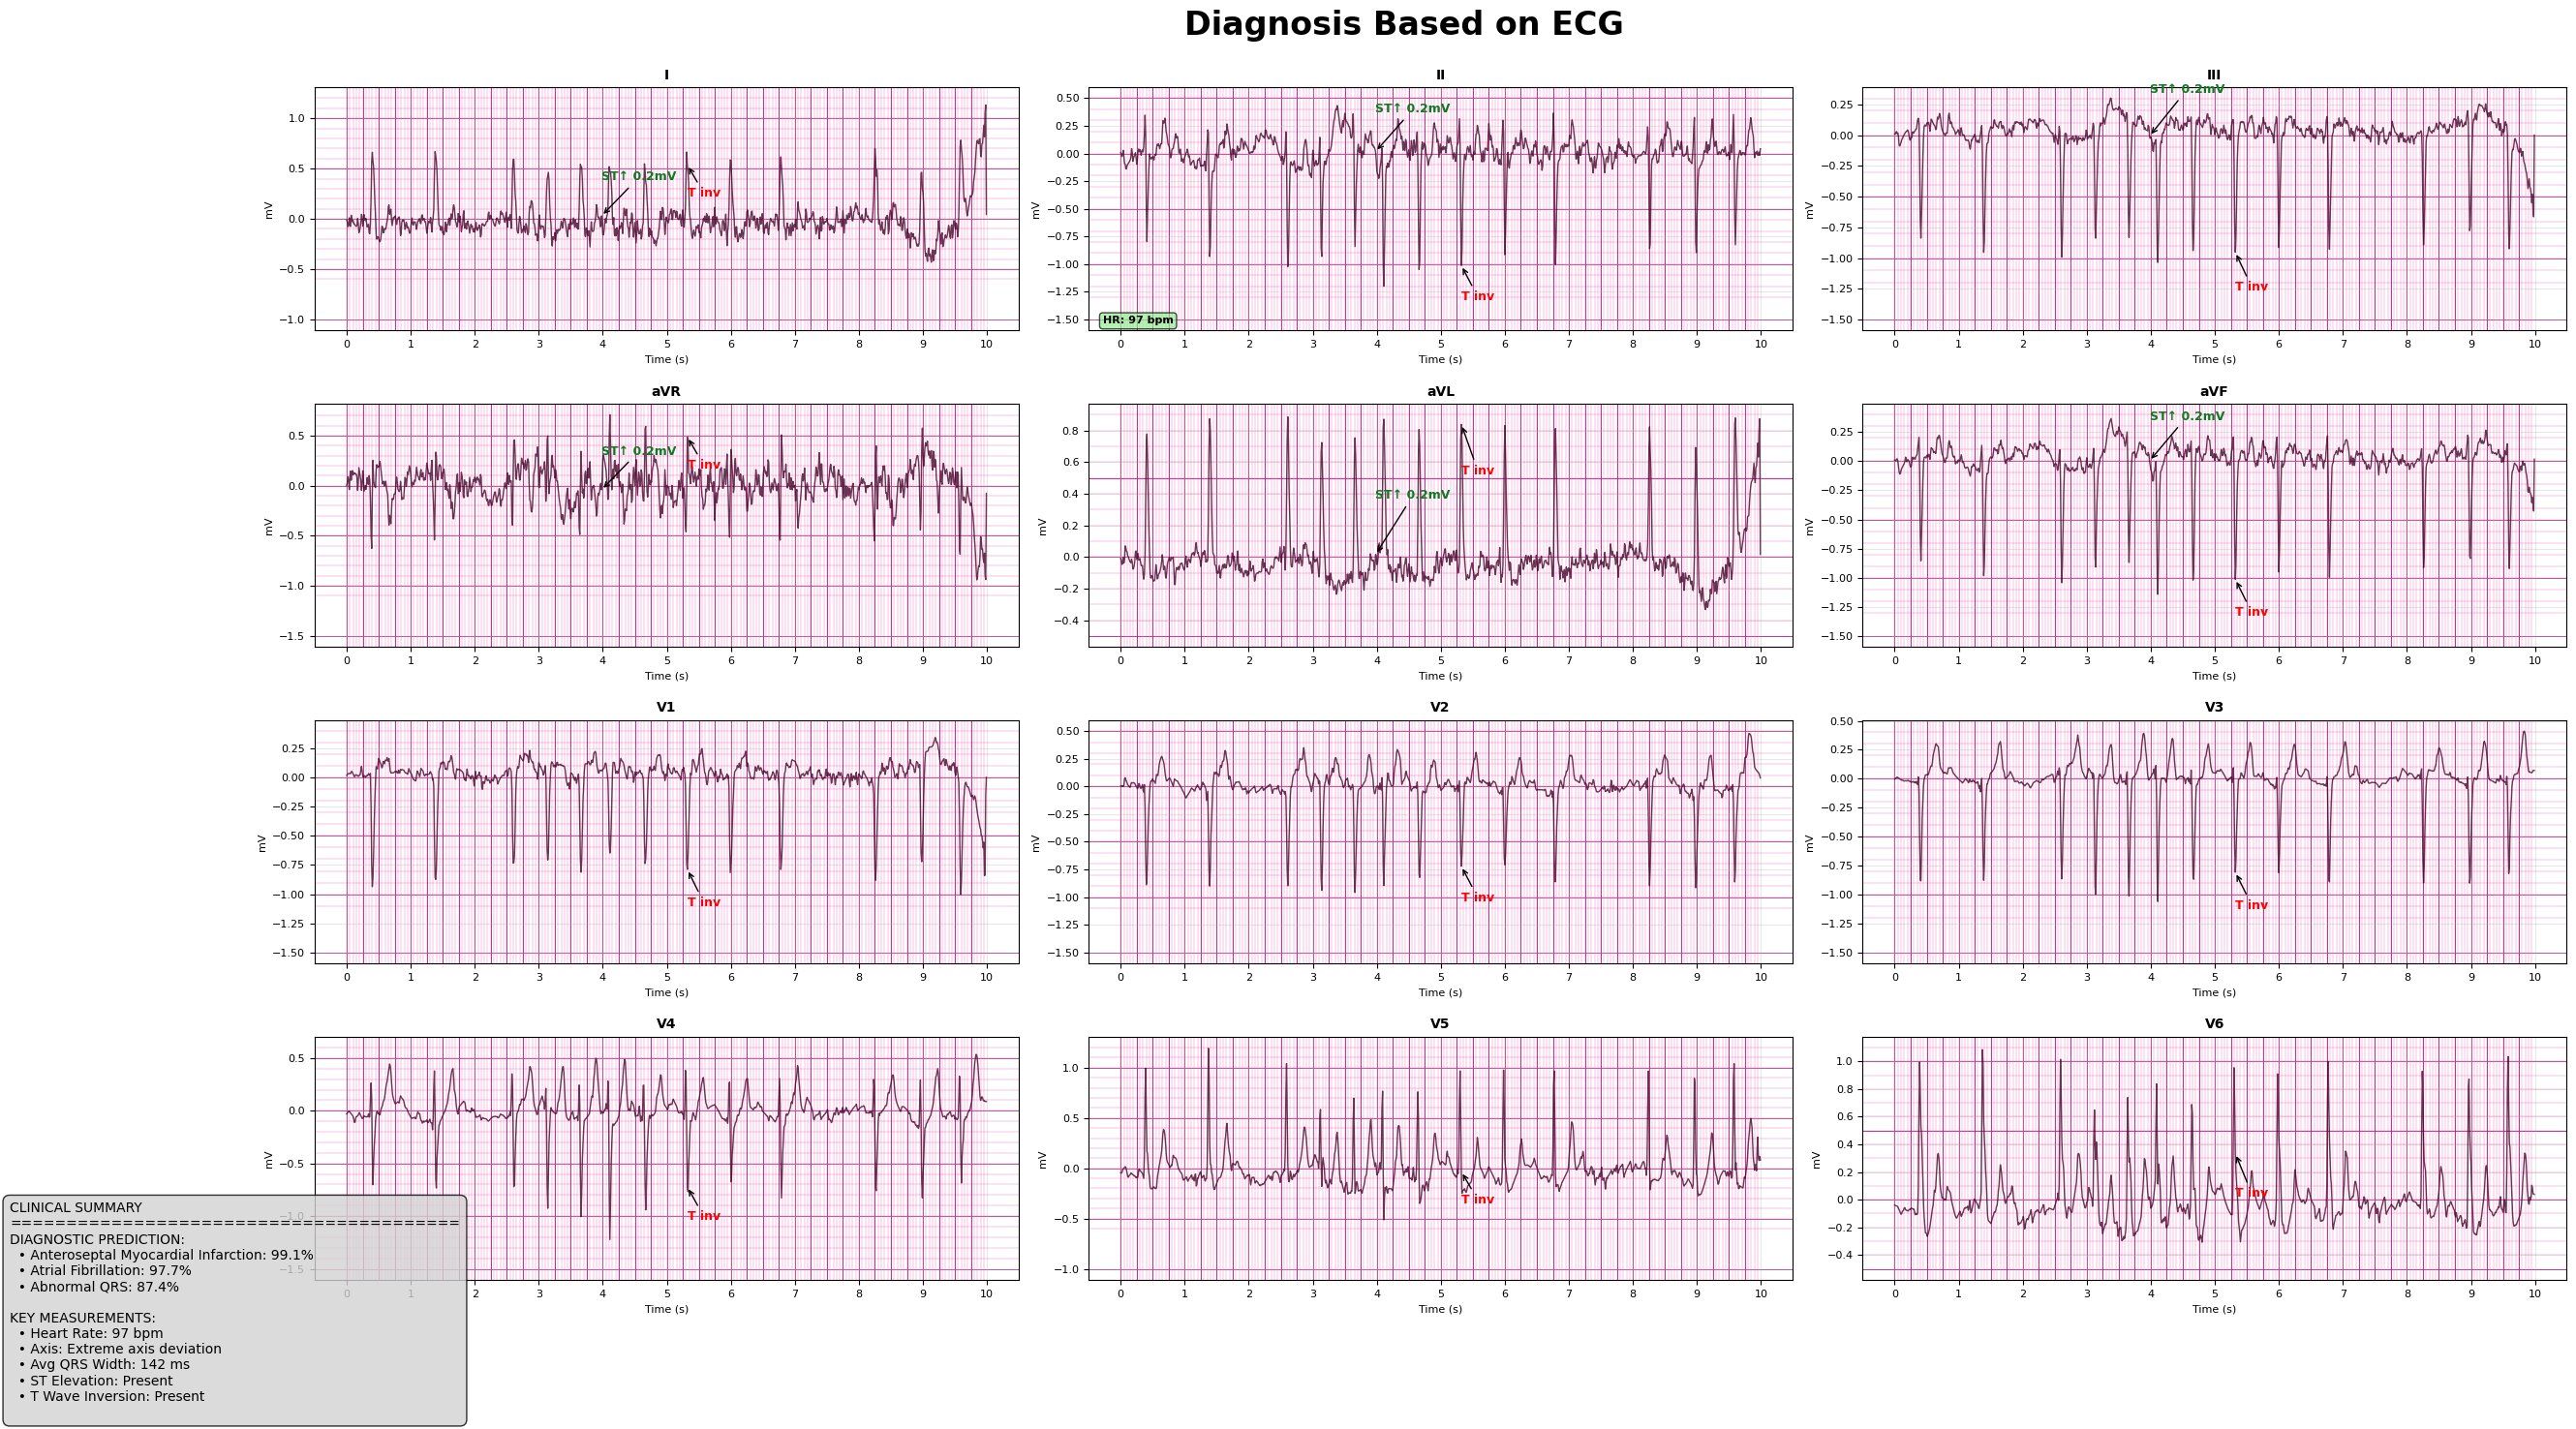

In [ ]:
# Clinical ECG visualization function
def add_ecg_grid(ax, duration_sec=10, mv_range=2, mm_per_sec=20, mm_per_mv=10):
    small_box_time = 1 / mm_per_sec
    small_box_mv = 1 / mm_per_mv

    big_box_time = 5 * small_box_time
    big_box_mv = 5 * small_box_mv

    ymin, ymax = ax.get_ylim()
    y_small = np.arange(np.floor(ymin / small_box_mv) * small_box_mv,
                        np.ceil(ymax / small_box_mv) * small_box_mv,
                        small_box_mv)
    for y in y_small:
        ax.axhline(y, color='#ed70bc', linewidth=0.3, zorder=0)

    y_big = np.arange(np.floor(ymin / big_box_mv) * big_box_mv,
                      np.ceil(ymax / big_box_mv) * big_box_mv,
                      big_box_mv)
    for y in y_big:
        ax.axhline(y, color='#b51777', linewidth=0.6, zorder=0)

    xmax = duration_sec
    x_small = np.arange(0, xmax, small_box_time)
    for x in x_small:
        ax.axvline(x, color='#ed70bc', linewidth=0.3, zorder=0)

    x_big = np.arange(0, xmax, big_box_time)
    for x in x_big:
        ax.axvline(x, color='#b51777', linewidth=0.6, zorder=0)

# Function to visualize ECG signals with clinical grid
class ECGClinicalAnalyzer:
    def __init__(self, sampling_rate=100):
        self.sampling_rate = 1000
        self.scaling_factor = 500
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        self.clinical_criteria = {
            # RHYTHM ABNORMALITIES
            'AFIB': {
                'name': 'Atrial Fibrillation',
                'criteria': [
                    {'type': 'rr_irregularity', 'threshold': 0.3, 'description': 'Irregular R-R intervals'},
                    {'type': 'p_wave_absent', 'threshold': 0.7, 'description': 'Absent P waves'},
                    {'type': 'fibrillatory_waves', 'threshold': 0.1, 'description': 'Fibrillatory waves'},
                    {'type': 'ventricular_rate', 'range': [60, 180], 'description': 'Heart rate 60-180 bpm'}
                ]
            },
            'AFL': {
                'name': 'Atrial Flutter',
                'criteria': [
                    {'type': 'flutter_waves', 'rate': [240, 350], 'description': 'Flutter waves 240-350 bpm'},
                    {'type': 'sawtooth_pattern', 'leads': ['II', 'III', 'aVF'], 'description': 'Sawtooth pattern in inferior leads'},
                    {'type': 'av_conduction', 'ratio': [2, 3, 4], 'description': 'Fixed AV conduction ratio'}
                ]
            },
            'AFLU': {
                'name': 'Atrial Flutter (variant)',
                'criteria': [
                    {'type': 'flutter_waves', 'rate': [240, 350], 'description': 'Flutter waves 240-350 bpm'},
                    {'type': 'variable_conduction', 'description': 'Variable AV conduction'}
                ]
            },
            'SVTAC': {
                'name': 'Supraventricular Tachycardia',
                'criteria': [
                    {'type': 'heart_rate', 'range': [150, 250], 'description': 'Heart rate 150-250 bpm'},
                    {'type': 'narrow_qrs', 'threshold': 0.12, 'description': 'QRS < 120ms'},
                    {'type': 'regular_rhythm', 'description': 'Regular rhythm'}
                ]
            },
            'STACH': {
                'name': 'Sinus Tachycardia',
                'criteria': [
                    {'type': 'heart_rate', 'range': [100, 150], 'description': 'Heart rate 100-150 bpm'},
                    {'type': 'normal_p_waves', 'description': 'Normal P waves'},
                    {'type': 'regular_rhythm', 'description': 'Regular sinus rhythm'}
                ]
            },
            'SBRAD': {
                'name': 'Sinus Bradycardia',
                'criteria': [
                    {'type': 'heart_rate', 'range': [40, 60], 'description': 'Heart rate < 60 bpm'},
                    {'type': 'normal_p_waves', 'description': 'Normal P waves'},
                    {'type': 'regular_rhythm', 'description': 'Regular sinus rhythm'}
                ]
            },
            'SARRH': {
                'name': 'Sinus Arrhythmia',
                'criteria': [
                    {'type': 'rr_variability', 'threshold': 0.16, 'description': 'R-R interval variability > 0.16s'},
                    {'type': 'normal_p_waves', 'description': 'Normal P waves'},
                    {'type': 'respiratory_variation', 'description': 'Respiratory variation'}
                ]
            },
            'PACE': {
                'name': 'Paced Rhythm',
                'criteria': [
                    {'type': 'pacing_spikes', 'description': 'Pacing spikes present'},
                    {'type': 'wide_qrs', 'threshold': 0.12, 'description': 'Wide QRS > 120ms'},
                    {'type': 'av_pacing', 'description': 'Atrial/Ventricular pacing'}
                ]
            },
            'BIGU': {
                'name': 'Bigeminy',
                'criteria': [
                    {'type': 'alternating_pattern', 'description': 'Alternating normal-PVC pattern'},
                    {'type': 'premature_beats', 'description': 'Every other beat is premature'}
                ]
            },
            'TRIGU': {
                'name': 'Trigeminy',
                'criteria': [
                    {'type': 'every_third_beat', 'description': 'Every third beat is premature'},
                    {'type': 'regular_pattern', 'description': 'Regular trigeminal pattern'}
                ]
            },

            # CONDUCTION ABNORMALITIES
            'IAVB': {
                'name': '1st Degree AV Block',
                'criteria': [
                    {'type': 'pr_interval', 'threshold': 0.20, 'description': 'PR interval > 200ms'},
                    {'type': 'all_p_conducted', 'description': 'All P waves conducted'}
                ]
            },
            'IIAVB': {
                'name': '2nd Degree AV Block',
                'criteria': [
                    {'type': 'dropped_qrs', 'description': 'Some P waves not conducted'},
                    {'type': 'wenckebach_pattern', 'description': 'Progressive PR prolongation'}
                ]
            },
            'IIAVBII': {
                'name': '2nd Degree AV Block Type II',
                'criteria': [
                    {'type': 'sudden_dropped_qrs', 'description': 'Sudden dropped QRS'},
                    {'type': 'constant_pr', 'description': 'Constant PR interval'}
                ]
            },
            'IIAVBI': {
                'name': '2nd Degree AV Block Type I',
                'criteria': [
                    {'type': 'wenckebach_pattern', 'description': 'Progressive PR prolongation'},
                    {'type': 'grouped_beating', 'description': 'Grouped beating pattern'}
                ]
            },
            'IIAVB': {
                'name': '3rd Degree AV Block',
                'criteria': [
                    {'type': 'av_dissociation', 'description': 'Complete AV dissociation'},
                    {'type': 'escape_rhythm', 'description': 'Junctional/ventricular escape'}
                ]
            },
            'LAFB': {
                'name': 'Left Anterior Fascicular Block',
                'criteria': [
                    {'type': 'left_axis_deviation', 'threshold': -45, 'description': 'Left axis deviation < -45°'},
                    {'type': 'qr_pattern', 'leads': ['I', 'aVL'], 'description': 'qR pattern in I, aVL'},
                    {'type': 'rs_pattern', 'leads': ['II', 'III', 'aVF'], 'description': 'rS pattern in inferior leads'}
                ]
            },
            'LPFB': {
                'name': 'Left Posterior Fascicular Block',
                'criteria': [
                    {'type': 'right_axis_deviation', 'threshold': 90, 'description': 'Right axis deviation > 90°'},
                    {'type': 'rs_pattern', 'leads': ['I', 'aVL'], 'description': 'rS pattern in I, aVL'},
                    {'type': 'qr_pattern', 'leads': ['II', 'III', 'aVF'], 'description': 'qR pattern in inferior leads'}
                ]
            },
            'LPR': {
                'name': 'Long PR Interval',
                'criteria': [
                    {'type': 'pr_interval', 'threshold': 0.20, 'description': 'PR interval > 200ms'},
                    {'type': 'all_p_conducted', 'description': 'All P waves conducted'}
                ]
            },
            'CLBBB': {
                'name': 'Complete Left Bundle Branch Block',
                'criteria': [
                    {'type': 'qrs_width', 'threshold': 0.12, 'description': 'QRS ≥ 120ms'},
                    {'type': 'broad_r_wave', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'Broad R wave in I, aVL, V5, V6'},
                    {'type': 'absent_q_waves', 'leads': ['I', 'V5', 'V6'], 'description': 'Absent Q waves in I, V5, V6'}
                ]
            },
            'CRBBB': {
                'name': 'Complete Right Bundle Branch Block',
                'criteria': [
                    {'type': 'qrs_width', 'threshold': 0.12, 'description': 'QRS ≥ 120ms'},
                    {'type': 'rsr_pattern', 'leads': ['V1', 'V2'], 'description': 'rSR\' pattern in V1, V2'},
                    {'type': 'wide_s_wave', 'leads': ['I', 'V6'], 'description': 'Wide S wave in I, V6'}
                ]
            },
            'ILBBB': {
                'name': 'Incomplete Left Bundle Branch Block',
                'criteria': [
                    {'type': 'qrs_width', 'range': [0.10, 0.12], 'description': 'QRS 100-120ms'},
                    {'type': 'left_axis_deviation', 'description': 'Left axis deviation'},
                    {'type': 'delayed_r_wave', 'leads': ['V5', 'V6'], 'description': 'Delayed R wave in V5, V6'}
                ]
            },
            'IRBBB': {
                'name': 'Incomplete Right Bundle Branch Block',
                'criteria': [
                    {'type': 'qrs_width', 'range': [0.10, 0.12], 'description': 'QRS 100-120ms'},
                    {'type': 'rsr_pattern', 'leads': ['V1', 'V2'], 'description': 'rSR\' pattern in V1, V2'},
                    {'type': 'terminal_r_wave', 'leads': ['V1'], 'description': 'Terminal R wave in V1'}
                ]
            },
            'ISCAL': {
                'name': 'Ischemia Anterolateral',
                'criteria': [
                    {'type': 'st_depression', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'ST depression in I, aVL, V5, V6'},
                    {'type': 't_wave_inversion', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'T wave inversion'}
                ]
            },
            'ISCAN': {
                'name': 'Ischemia Anterior',
                'criteria': [
                    {'type': 'st_depression', 'leads': ['V1', 'V2', 'V3', 'V4'], 'description': 'ST depression in V1-V4'},
                    {'type': 't_wave_inversion', 'leads': ['V1', 'V2', 'V3', 'V4'], 'description': 'T wave inversion in precordial leads'}
                ]
            },
            'ISCIN': {
                'name': 'Ischemia Inferior',
                'criteria': [
                    {'type': 'st_depression', 'leads': ['II', 'III', 'aVF'], 'description': 'ST depression in II, III, aVF'},
                    {'type': 't_wave_inversion', 'leads': ['II', 'III', 'aVF'], 'description': 'T wave inversion in inferior leads'}
                ]
            },
            'ISCLA': {
                'name': 'Ischemia Lateral',
                'criteria': [
                    {'type': 'st_depression', 'leads': ['I', 'aVL', 'V6'], 'description': 'ST depression in I, aVL, V6'},
                    {'type': 't_wave_inversion', 'leads': ['I', 'aVL', 'V6'], 'description': 'T wave inversion in lateral leads'}
                ]
            },
            'ISCI': {
                'name': 'Ischemia Inferolateral',
                'criteria': [
                    {'type': 'st_depression', 'leads': ['II', 'III', 'aVF', 'V5', 'V6'], 'description': 'ST depression in inferior and lateral leads'},
                    {'type': 't_wave_inversion', 'leads': ['II', 'III', 'aVF', 'V5', 'V6'], 'description': 'T wave inversion'}
                ]
            },

            # MYOCARDIAL INFARCTION
            'STTC': {
                'name': 'ST-T Changes',
                'criteria': [
                    {'type': 'st_elevation', 'threshold': 0.1, 'description': 'ST elevation > 1mm'},
                    {'type': 'st_depression', 'threshold': 0.1, 'description': 'ST depression > 1mm'},
                    {'type': 't_wave_changes', 'description': 'T wave abnormalities'}
                ]
            },
            'NST_': {
                'name': 'Nonspecific ST-T Changes',
                'criteria': [
                    {'type': 'minor_st_changes', 'description': 'Minor ST changes'},
                    {'type': 'nonspecific_t_changes', 'description': 'Nonspecific T wave changes'}
                ]
            },
            'IMI': {
                'name': 'Inferior Myocardial Infarction',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['II', 'III', 'aVF'], 'description': 'Q waves in II, III, aVF'},
                    {'type': 'st_elevation', 'leads': ['II', 'III', 'aVF'], 'description': 'ST elevation in inferior leads'},
                    {'type': 'reciprocal_changes', 'leads': ['I', 'aVL'], 'description': 'Reciprocal changes in I, aVL'}
                ]
            },
            'AMI': {
                'name': 'Anterior Myocardial Infarction',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['V1', 'V2', 'V3', 'V4'], 'description': 'Q waves in V1-V4'},
                    {'type': 'st_elevation', 'leads': ['V1', 'V2', 'V3', 'V4'], 'description': 'ST elevation in precordial leads'},
                    {'type': 'poor_r_progression', 'leads': ['V1', 'V2', 'V3'], 'description': 'Poor R wave progression'}
                ]
            },
            'ALMI': {
                'name': 'Anterolateral Myocardial Infarction',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['I', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'description': 'Q waves in anterior and lateral leads'},
                    {'type': 'st_elevation', 'leads': ['I', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'description': 'ST elevation'}
                ]
            },
            'LMI': {
                'name': 'Lateral Myocardial Infarction',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'Q waves in I, aVL, V5, V6'},
                    {'type': 'st_elevation', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'ST elevation in lateral leads'}
                ]
            },
            'ASMI': {
                'name': 'Anteroseptal Myocardial Infarction',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['V1', 'V2', 'V3'], 'description': 'Q waves in V1-V3'},
                    {'type': 'poor_r_progression', 'leads': ['V1', 'V2', 'V3'], 'description': 'Poor R wave progression'}
                ]
            },
            'INJAS': {
                'name': 'Injury/Ischemia',
                'criteria': [
                    {'type': 'st_elevation', 'description': 'ST elevation'},
                    {'type': 'hyperacute_t_waves', 'description': 'Hyperacute T waves'},
                    {'type': 'reciprocal_changes', 'description': 'Reciprocal ST depression'}
                ]
            },
            'INJAL': {
                'name': 'Injury Anterolateral',
                'criteria': [
                    {'type': 'st_elevation', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'ST elevation in I, aVL, V5, V6'},
                    {'type': 'hyperacute_t_waves', 'leads': ['I', 'aVL', 'V5', 'V6'], 'description': 'Hyperacute T waves'}
                ]
            },
            'INJIN': {
                'name': 'Injury Inferior',
                'criteria': [
                    {'type': 'st_elevation', 'leads': ['II', 'III', 'aVF'], 'description': 'ST elevation in II, III, aVF'},
                    {'type': 'hyperacute_t_waves', 'leads': ['II', 'III', 'aVF'], 'description': 'Hyperacute T waves'}
                ]
            },
            'INJLA': {
                'name': 'Injury Lateral',
                'criteria': [
                    {'type': 'st_elevation', 'leads': ['I', 'aVL', 'V6'], 'description': 'ST elevation in I, aVL, V6'},
                    {'type': 'hyperacute_t_waves', 'leads': ['I', 'aVL', 'V6'], 'description': 'Hyperacute T waves'}
                ]
            },
            'IPLMI': {
                'name': 'Inferoposterolateral MI',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['II', 'III', 'aVF', 'V5', 'V6'], 'description': 'Q waves in inferior and lateral leads'},
                    {'type': 'tall_r_waves', 'leads': ['V1', 'V2'], 'description': 'Tall R waves in V1, V2 (posterior)'}
                ]
            },
            'IPMI': {
                'name': 'Inferoposterior MI',
                'criteria': [
                    {'type': 'q_waves', 'leads': ['II', 'III', 'aVF'], 'description': 'Q waves in inferior leads'},
                    {'type': 'tall_r_waves', 'leads': ['V1', 'V2'], 'description': 'Tall R waves in V1, V2'}
                ]
            },

            # HYPERTROPHY
            'LVH': {
                'name': 'Left Ventricular Hypertrophy',
                'criteria': [
                    {'type': 'sokolow_lyon', 'threshold': 3.5, 'description': 'S(V1) + R(V5/V6) > 3.5mV'},
                    {'type': 'cornell_criteria', 'description': 'Cornell voltage criteria'},
                    {'type': 'st_depression', 'leads': ['V5', 'V6'], 'description': 'ST depression with strain pattern'}
                ]
            },
            'RVH': {
                'name': 'Right Ventricular Hypertrophy',
                'criteria': [
                    {'type': 'tall_r_wave', 'leads': ['V1'], 'description': 'Tall R wave in V1'},
                    {'type': 'right_axis_deviation', 'description': 'Right axis deviation'},
                    {'type': 'rv_strain', 'leads': ['V1', 'V2'], 'description': 'RV strain pattern'}
                ]
            },
            'HVOLT': {
                'name': 'High Voltage',
                'criteria': [
                    {'type': 'high_voltage', 'description': 'High voltage QRS complexes'},
                    {'type': 'voltage_criteria', 'description': 'Meets voltage criteria for hypertrophy'}
                ]
            },
            'LAO/LAE': {
                'name': 'Left Atrial Enlargement',
                'criteria': [
                    {'type': 'p_wave_duration', 'threshold': 0.12, 'description': 'P wave duration > 120ms'},
                    {'type': 'bifid_p_wave', 'leads': ['II'], 'description': 'Bifid P wave in II'},
                    {'type': 'terminal_p_force', 'leads': ['V1'], 'description': 'Terminal P force in V1'}
                ]
            },
            'RAO/RAE': {
                'name': 'Right Atrial Enlargement',
                'criteria': [
                    {'type': 'tall_p_wave', 'leads': ['II'], 'threshold': 0.25, 'description': 'Tall P wave in II > 2.5mm'},
                    {'type': 'peaked_p_wave', 'description': 'Peaked P waves'},
                    {'type': 'right_axis_p', 'description': 'Right axis deviation of P wave'}
                ]
            },

            # ARRHYTHMIAS
            'SVARR': {
                'name': 'Supraventricular Arrhythmia',
                'criteria': [
                    {'type': 'irregular_rhythm', 'description': 'Irregular supraventricular rhythm'},
                    {'type': 'narrow_qrs', 'description': 'Narrow QRS complexes'},
                    {'type': 'variable_morphology', 'description': 'Variable P wave morphology'}
                ]
            },
            'VCLVH': {
                'name': 'Voltage Criteria for LVH',
                'criteria': [
                    {'type': 'voltage_criteria', 'description': 'Meets voltage criteria for LVH'},
                    {'type': 'no_strain_pattern', 'description': 'No strain pattern present'}
                ]
            },
            'QWAVE': {
                'name': 'Q Wave Abnormality',
                'criteria': [
                    {'type': 'pathological_q_waves', 'description': 'Pathological Q waves present'},
                    {'type': 'q_wave_duration', 'threshold': 0.04, 'description': 'Q wave duration > 40ms'},
                    {'type': 'q_wave_depth', 'threshold': 0.25, 'description': 'Q wave depth > 25% of R wave'}
                ]
            },
            'PRWP': {
                'name': 'Poor R Wave Progression',
                'criteria': [
                    {'type': 'poor_r_progression', 'leads': ['V1', 'V2', 'V3'], 'description': 'Poor R wave progression V1-V3'},
                    {'type': 'rv_transition', 'description': 'Delayed R/S transition'}
                ]
            },
            'LOWT': {
                'name': 'Low T Wave Amplitude',
                'criteria': [
                    {'type': 'low_t_waves', 'description': 'Low amplitude T waves'},
                    {'type': 'flat_t_waves', 'description': 'Flat T waves'}
                ]
            },
            'NT_': {
                'name': 'Nonspecific T Wave Abnormality',
                'criteria': [
                    {'type': 'nonspecific_t_changes', 'description': 'Nonspecific T wave changes'},
                    {'type': 'minor_t_abnormalities', 'description': 'Minor T wave abnormalities'}
                ]
            },
            'TAB_': {
                'name': 'T Wave Abnormality',
                'criteria': [
                    {'type': 't_wave_inversion', 'description': 'T wave inversion'},
                    {'type': 't_wave_flattening', 'description': 'T wave flattening'},
                    {'type': 'biphasic_t_waves', 'description': 'Biphasic T waves'}
                ]
            },
            'INVT': {
                'name': 'Inverted T Waves',
                'criteria': [
                    {'type': 't_wave_inversion', 'description': 'T wave inversion'},
                    {'type': 'deep_t_inversion', 'description': 'Deep T wave inversion'}
                ]
            },
            'LVOLT': {
                'name': 'Low Voltage',
                'criteria': [
                    {'type': 'low_voltage_limb', 'threshold': 0.5, 'description': 'Low voltage in limb leads < 5mm'},
                    {'type': 'low_voltage_precordial', 'threshold': 1.0, 'description': 'Low voltage in precordial leads < 10mm'}
                ]
            },
            'NORM': {
                'name': 'Normal ECG',
                'criteria': [
                    {'type': 'normal_rhythm', 'description': 'Normal sinus rhythm'},
                    {'type': 'normal_axis', 'description': 'Normal axis'},
                    {'type': 'normal_intervals', 'description': 'Normal intervals'},
                    {'type': 'normal_morphology', 'description': 'Normal QRS and T wave morphology'}
                ]
            },
            'SR': {
              'name': 'Sinus Rhythm',
              'criteria': [
                  {'type': 'p_wave_present', 'description': 'P wave present before every QRS'},
                  {'type': 'rr_regular', 'description': 'Regular RR intervals'},
                  {'type': 'normal_heart_rate', 'description': 'Heart rate between 60–100 bpm'},
                  {'type': 'normal_axis', 'description': 'Normal axis (QRS axis between -30° and +90°)'}
              ]
          },
            'ABQRS': {
                'name': 'Abnormal QRS',
                'criteria': [
                    {'type': 'abnormal_qrs_morphology', 'description': 'Abnormal QRS morphology'},
                    {'type': 'wide_qrs', 'description': 'Wide QRS complexes'}
                ]
            },
            'PVC': {
                'name': 'Premature Ventricular Contractions',
                'criteria': [
                    {'type': 'premature_beats', 'description': 'Premature ventricular beats'},
                    {'type': 'wide_qrs', 'description': 'Wide QRS > 120ms'},
                    {'type': 'compensatory_pause', 'description': 'Compensatory pause'}
                ]
            },
            'SPB': {
                'name': 'Supraventricular Premature Beats',
                'criteria': [
                    {'type': 'premature_beats', 'description': 'Premature supraventricular beats'},
                    {'type': 'narrow_qrs', 'description': 'Narrow QRS complexes'},
                    {'type': 'abnormal_p_wave', 'description': 'Abnormal P wave morphology'}
                ]
            },
            'PSVT': {
                'name': 'Paroxysmal Supraventricular Tachycardia',
                'criteria': [
                    {'type': 'rapid_rate', 'range': [150, 250], 'description': 'Rapid heart rate 150-250 bpm'},
                    {'type': 'narrow_qrs', 'description': 'Narrow QRS complexes'},
                    {'type': 'regular_rhythm', 'description': 'Regular rhythm'}
                ]
            },
            'VTAC': {
                'name': 'Ventricular Tachycardia',
                'criteria': [
                    {'type': 'rapid_rate', 'range': [150, 250], 'description': 'Rapid heart rate 150-250 bpm'},
                    {'type': 'wide_qrs', 'threshold': 0.12, 'description': 'Wide QRS > 120ms'},
                    {'type': 'av_dissociation', 'description': 'AV dissociation'}
                ]
            },
            'VFIB': {
                'name': 'Ventricular Fibrillation',
                'criteria': [
                    {'type': 'chaotic_rhythm', 'description': 'Chaotic ventricular rhythm'},
                    {'type': 'no_qrs_complexes', 'description': 'No identifiable QRS complexes'},
                    {'type': 'irregular_waves', 'description': 'Irregular fibrillatory waves'}
                ]
            },
            'ASYS': {
                'name': 'Asystole',
                'criteria': [
                    {'type': 'no_electrical_activity', 'description': 'No electrical activity'},
                    {'type': 'flat_line', 'description': 'Flat line or minimal'},
                    {'type': 'activity', 'description': 'Minimal electrical activity'}
                ]
            }
        }

    def check_scaling(self, ecg_signal):
        for factor in [1, 10, 100, 1000]:
            scaled = ecg_signal / factor


    def detect_r_peaks(self, ecg_signal, lead=1):
        """Detect R peaks in ECG signal"""
        from scipy.signal import find_peaks

        if lead >= len(ecg_signal):
            lead = 1

        signal_data = ecg_signal[lead]
        
        height = np.max(signal_data) * 0.5 
        distance = int(0.6 * self.sampling_rate)
        peaks, _ = find_peaks(signal_data, height=height, distance=distance)
        return peaks


    def calculate_rr_intervals(self, r_peaks):
        """Calculate R-R intervals"""
        if len(r_peaks) < 2:
            return []

        rr_intervals = np.diff(r_peaks) / self.sampling_rate
        return rr_intervals

    def calculate_heart_rate(self, rr_intervals):
        """Calculate heart rate from R-R intervals"""
        if len(rr_intervals) == 0:
            return 0

        avg_rr = np.mean(rr_intervals)
        heart_rate = 60 / avg_rr if avg_rr > 0 else 0
        return heart_rate

    def detect_qrs_width(self, ecg_signal, r_peaks, lead=1):
        """Detect QRS width"""
        if len(r_peaks) < 2:
            return []

        qrs_widths = []
        signal_data = ecg_signal[lead]

        for peak in r_peaks:
            q_search_start = max(0, peak - int(0.08 * self.sampling_rate))
            q_search_end = peak

            s_search_start = peak
            s_search_end = min(len(signal_data), peak + int(0.08 * self.sampling_rate))

            qrs_width = (s_search_end - q_search_start) / self.sampling_rate
            qrs_widths.append(qrs_width)

        return qrs_widths

    def detect_st_changes(self, ecg_signal, r_peaks, lead=1):
        """Detect ST elevation/depression """
        if len(r_peaks) < 2:
            return {'elevation': [], 'depression': []}

        signal_data = ecg_signal[lead]
        st_changes = {'elevation': [], 'depression': []}

        for peak in r_peaks:
            j_point = peak + int(0.06 * self.sampling_rate)

            if j_point < len(signal_data):
                baseline_start = max(0, peak - int(0.25 * self.sampling_rate))
                baseline_end = max(0, peak - int(0.15 * self.sampling_rate))

                if baseline_end > baseline_start:
                    baseline = np.mean(signal_data[baseline_start:baseline_end])
                    st_value = signal_data[j_point]
                    deviation = st_value - baseline

                    if deviation > 0.2:
                        st_changes['elevation'].append((j_point, deviation))
                    elif deviation < -0.2:
                        st_changes['depression'].append((j_point, deviation))

        return st_changes


    def detect_t_wave_changes(self, ecg_signal, r_peaks, lead=1):
        """Detect T wave abnormalities"""
        if len(r_peaks) < 2:
            return {'inverted': [], 'flat': [], 'peaked': []}

        signal_data = ecg_signal[lead]
        t_changes = {'inverted': [], 'flat': [], 'peaked': []}

        for i, peak in enumerate(r_peaks[:-1]):
            t_start = peak + int(0.15 * self.sampling_rate)
            t_end = min(len(signal_data), peak + int(0.4 * self.sampling_rate))

            if t_end > t_start:
                t_segment = signal_data[t_start:t_end]

                t_peak_idx = np.argmax(np.abs(t_segment))
                t_peak_value = t_segment[t_peak_idx]
                t_peak_pos = t_start + t_peak_idx

                baseline_start = max(0, peak - int(0.2 * self.sampling_rate))
                baseline_end = max(0, peak - int(0.1 * self.sampling_rate))

                if baseline_end > baseline_start:
                    baseline = np.mean(signal_data[baseline_start:baseline_end])
                    
                    if t_peak_value < baseline - 0.1:
                        t_changes['inverted'].append((t_peak_pos, t_peak_value))
                    elif abs(t_peak_value - baseline) < 0.05:
                        t_changes['flat'].append((t_peak_pos, t_peak_value))
                    elif t_peak_value > baseline + 0.5:
                        t_changes['peaked'].append((t_peak_pos, t_peak_value))

        return t_changes

    def detect_p_waves(self, ecg_signal, r_peaks, lead=1):
        """Detect P waves and abnormalities"""
        if len(r_peaks) < 2:
            return {'present': [], 'absent': [], 'abnormal': []}

        signal_data = ecg_signal[lead]
        p_waves = {'present': [], 'absent': [], 'abnormal': []}

        for peak in r_peaks:
            p_search_start = max(0, peak - int(0.25 * self.sampling_rate))
            p_search_end = max(0, peak - int(0.08 * self.sampling_rate))

            if p_search_end > p_search_start:
                p_segment = signal_data[p_search_start:p_search_end]

                p_peak_idx = np.argmax(p_segment)
                p_peak_value = p_segment[p_peak_idx]
                p_peak_pos = p_search_start + p_peak_idx
                baseline_start = max(0, peak - int(0.4 * self.sampling_rate))
                baseline_end = max(0, peak - int(0.3 * self.sampling_rate))

                if baseline_end > baseline_start:
                    baseline = np.mean(signal_data[baseline_start:baseline_end])

                    # P wave detection
                    if p_peak_value > baseline + 0.05:
                        p_duration = len(p_segment) / self.sampling_rate

                        if p_duration > 0.12:
                            p_waves['abnormal'].append((p_peak_pos, p_peak_value, 'prolonged'))
                        elif p_peak_value > baseline + 0.25:
                            p_waves['abnormal'].append((p_peak_pos, p_peak_value, 'tall'))
                        else:
                            p_waves['present'].append((p_peak_pos, p_peak_value))
                    else:
                        p_waves['absent'].append((p_peak_pos, 0))

        return p_waves


    def analyze_axis_deviation(self, ecg_signal):
        lead_i = ecg_signal[0] if len(ecg_signal) > 0 else np.zeros(1000)
        lead_avf = ecg_signal[5] if len(ecg_signal) > 5 else np.zeros(1000)

        net_i = np.mean(lead_i)
        net_avf = np.mean(lead_avf)

        if net_i > 0 and net_avf > 0:
            axis = "Normal (0° to +90°)"
        elif net_i > 0 and net_avf < 0:
            axis = "Left axis deviation (-30° to -90°)"
        elif net_i < 0 and net_avf > 0:
            axis = "Right axis deviation (+90° to +180°)"
        else:
            axis = "Extreme axis deviation"

        return axis, net_i, net_avf

    def evaluate_clinical_criteria(self, ecg_signal, condition_code):
        """Evaluate clinical criteria for a specific condition"""
        if condition_code not in self.clinical_criteria:
            return {"error": f"Unknown condition: {condition_code}"}

        criteria = self.clinical_criteria[condition_code]
        results = {
            'condition': criteria['name'],
            'criteria_met': [],
            'criteria_not_met': [],
            'clinical_evidence': {},
            'confidence': 0
        }

        r_peaks = self.detect_r_peaks(ecg_signal)
        rr_intervals = self.calculate_rr_intervals(r_peaks)
        heart_rate = self.calculate_heart_rate(rr_intervals)
        qrs_widths = self.detect_qrs_width(ecg_signal, r_peaks)
        st_changes = self.detect_st_changes(ecg_signal, r_peaks)
        t_changes = self.detect_t_wave_changes(ecg_signal, r_peaks)
        p_waves = self.detect_p_waves(ecg_signal, r_peaks)
        axis, net_i, net_avf = self.analyze_axis_deviation(ecg_signal)

        results['clinical_evidence'] = {
            'r_peaks': r_peaks,
            'rr_intervals': rr_intervals,
            'heart_rate': heart_rate,
            'qrs_widths': qrs_widths,
            'st_changes': st_changes,
            't_changes': t_changes,
            'p_waves': p_waves,
            'axis': axis,
            'net_i': net_i,
            'net_avf': net_avf
        }

        criteria_met = 0
        total_criteria = len(criteria['criteria'])

        for criterion in criteria['criteria']:
            criterion_met = False

            if criterion['type'] == 'heart_rate':
                if 'range' in criterion:
                    if criterion['range'][0] <= heart_rate <= criterion['range'][1]:
                        criterion_met = True

            elif criterion['type'] == 'rr_irregularity':
                if len(rr_intervals) > 1:
                    rr_std = np.std(rr_intervals)
                    if rr_std > criterion['threshold']:
                        criterion_met = True

            elif criterion['type'] == 'qrs_width':
                if len(qrs_widths) > 0:
                    avg_qrs = np.mean(qrs_widths)
                    if 'threshold' in criterion:
                        if avg_qrs >= criterion['threshold']:
                            criterion_met = True
                    elif 'range' in criterion:
                        if criterion['range'][0] <= avg_qrs <= criterion['range'][1]:
                            criterion_met = True

            elif criterion['type'] == 'st_elevation':
                if len(st_changes['elevation']) > 0:
                    criterion_met = True

            elif criterion['type'] == 'st_depression':
                if len(st_changes['depression']) > 0:
                    criterion_met = True

            elif criterion['type'] == 't_wave_inversion':
                if len(t_changes['inverted']) > 0:
                    criterion_met = True

            elif criterion['type'] == 'p_wave_absent':
                if len(p_waves['absent']) > len(p_waves['present']):
                    criterion_met = True

            elif criterion['type'] == 'left_axis_deviation':
                if "Left axis" in axis:
                    criterion_met = True

            elif criterion['type'] == 'right_axis_deviation':
                if "Right axis" in axis:
                    criterion_met = True

            if criterion_met:
                results['criteria_met'].append(criterion['description'])
                criteria_met += 1
            else:
                results['criteria_not_met'].append(criterion['description'])

        results['confidence'] = criteria_met / total_criteria if total_criteria > 0 else 0
        return results


    def visualize_clinical_evidence(self, ecg_signal, predictions_dict, threshold=0.5):
        top_predictions = sorted([(code, prob) for code, prob in predictions_dict.items()
                                if prob >= threshold], key=lambda x: x[1], reverse=True)[:3]

        if not top_predictions:
            top_predictions = sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True)[:1]
            threshold = 0
        fig = plt.figure(figsize=(30, 16))
        gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.1)

        # Plot 12-lead ECG
        lead_positions = [
            (0, 0), (0, 1), (0, 2),  # I, II, III
            (1, 0), (1, 1), (1, 2),  # aVR, aVL, aVF
            (2, 0), (2, 1), (2, 2),  # V1, V2, V3
            (3, 0), (3, 1), (3, 2)   # V4, V5, V6
        ]

        all_evidence = {}
        for condition_code, prob in top_predictions:
            evaluation = self.evaluate_clinical_criteria(ecg_signal, condition_code)
            if 'error' not in evaluation:
                all_evidence[condition_code] = evaluation['clinical_evidence']

        combined_evidence = {
            'r_peaks': [],
            'rr_intervals': [],
            'heart_rate': 0,
            'qrs_widths': [],
            'st_changes': {'elevation': [], 'depression': []},
            't_changes': {'inverted': [], 'flat': [], 'peaked': []},
            'p_waves': {'present': [], 'absent': [], 'abnormal': []},
            'axis': "Normal",
            'net_i': 0,
            'net_avf': 0
        }

        for evidence in all_evidence.values():
            if len(evidence['r_peaks']) > 0 and len(combined_evidence['r_peaks']) == 0:
                combined_evidence['r_peaks'] = evidence['r_peaks']
            if len(evidence['rr_intervals']) > 0 and len(combined_evidence['rr_intervals']) == 0:
                combined_evidence['rr_intervals'] = evidence['rr_intervals']
            if evidence['heart_rate'] > 0 and combined_evidence['heart_rate'] == 0:
                combined_evidence['heart_rate'] = evidence['heart_rate']
            if len(evidence['qrs_widths']) > 0 and len(combined_evidence['qrs_widths']) == 0:
                combined_evidence['qrs_widths'] = evidence['qrs_widths']
            if len(evidence['st_changes']['elevation']) > 0 and len(combined_evidence['st_changes']['elevation']) == 0:
                combined_evidence['st_changes']['elevation'] = evidence['st_changes']['elevation']
            if len(evidence['st_changes']['depression']) > 0 and len(combined_evidence['st_changes']['depression']) == 0:
                combined_evidence['st_changes']['depression'] = evidence['st_changes']['depression']
            if len(evidence['t_changes']['inverted']) > 0 and len(combined_evidence['t_changes']['inverted']) == 0:
                combined_evidence['t_changes']['inverted'] = evidence['t_changes']['inverted']
            if evidence['axis'] != "Normal" and combined_evidence['axis'] == "Normal":
                combined_evidence['axis'] = evidence['axis']

        for i, (row, col) in enumerate(lead_positions):
            if i >= len(ecg_signal):
                break

            ax = fig.add_subplot(gs[row, col])
            time_axis = np.arange(len(ecg_signal[i])) / self.sampling_rate
            time_mm = time_axis * 10 


            ecg_mv = ecg_signal[i] / 5

            ax.plot(time_mm, ecg_mv, color='#44062a', linewidth=1, alpha=0.8)
            add_ecg_grid(ax, duration_sec=10, mv_range=2)
            ax.set_xticks(np.arange(0, 11, 1))
            self._annotate_common_findings(ax, time_axis, ecg_signal[i], combined_evidence, i)

            ax.set_title(f'{self.lead_names[i]}', fontsize=10, fontweight='bold')
            ax.set_xlabel('Time (s)', fontsize=8)
            ax.set_ylabel('mV', fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=8)



        fig.suptitle('Diagnosis Based on ECG', fontsize= 24, fontweight='bold',  y=0.93)

        combined_criteria = []
        for condition_code, prob in top_predictions:
            evaluation = self.evaluate_clinical_criteria(ecg_signal, condition_code)
            if 'error' not in evaluation:
                all_evidence[condition_code] = evaluation['clinical_evidence']
                combined_criteria.extend(evaluation['criteria_met'])

        summary_text = self._create_simplified_summary(top_predictions, combined_evidence, combined_criteria, threshold)

        fig.text(0.02, 0.02, summary_text, fontsize=10, verticalalignment='bottom',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        plt.tight_layout()
        plt.savefig("models/sample_prediction.png", dpi=300, bbox_inches='tight')
        plt.show()

        return all_evidence

    def _annotate_common_findings(self, ax, time_axis, signal, evidence, lead_idx):
          signal_mv = signal / 5

          # Annotate R peaks
          if len(evidence['r_peaks']) > 0:
              r_times = evidence['r_peaks'] / self.sampling_rate * 10
              r_values = signal_mv[evidence['r_peaks']]

          if lead_idx < 6:
              # ST elevations
              for st_point, deviation in evidence['st_changes']['elevation']:
                  st_time = st_point / self.sampling_rate * 10
                  if st_time < len(time_axis):
                      ax.annotate(f'ST↑ {deviation:.1f}mV',
                                xy=(st_time, signal_mv[st_point]),
                                xytext=(st_time, signal_mv[st_point] + 0.352),
                                arrowprops=dict(arrowstyle='->', color='black', lw=1),
                                fontsize=9, color='#0e7a23', fontweight='bold')

              # ST depressions
              for st_point, deviation in evidence['st_changes']['depression']:
                  st_time = st_point / self.sampling_rate * 10
                  if st_time < len(time_axis):
                      ax.annotate(f'ST↓ {deviation:.1f}mV',
                                xy=(st_time, signal_mv[st_point]),
                                xytext=(st_time, signal_mv[st_point] - 0.302),
                                arrowprops=dict(arrowstyle='->', color='black', lw=1),
                                fontsize=9, color='blue', fontweight='bold')

          # Annotate T wave inversions
          for t_point, value in evidence['t_changes']['inverted']:
              t_time = t_point / self.sampling_rate * 10
              if t_time < len(time_axis):
                  ax.annotate('T inv',
                            xy=(t_time, signal_mv[t_point]),
                            xytext=(t_time, signal_mv[t_point] - 0.315),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1),
                            fontsize=9, color='red', fontweight='bold')

          if lead_idx == 1:
              ax.text(0.02, 0.02, f'HR: {evidence["heart_rate"]:.0f} bpm',
                    transform=ax.transAxes, fontsize=8,
                    verticalalignment='bottom', fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

    def _create_simplified_summary(self, predictions, evidence,criteria_met=None, threshold=0.3):

        summary = "CLINICAL SUMMARY\n"
        summary += "=" * 40 + "\n"

        filtered_predictions = [(code, prob) for code, prob in predictions if prob >= threshold]

        if filtered_predictions:
            summary += "DIAGNOSTIC PREDICTION:\n".format(int(threshold*100))
            for condition_code, prob in filtered_predictions:
                condition_name = self.clinical_criteria.get(condition_code, {}).get('name', condition_code)
                summary += f"  • {condition_name}: {prob:.1%}\n"
        else:
            summary += "NO SIGNIFICANT PREDICTIONS\n"

        summary += "\nKEY MEASUREMENTS:\n"
        summary += f"  • Heart Rate: {evidence['heart_rate']:.0f} bpm\n"
        summary += f"  • Axis: {evidence['axis']}\n"

        if len(evidence['qrs_widths']) > 0:
            summary += f"  • Avg QRS Width: {np.mean(evidence['qrs_widths'])*1000:.0f} ms\n"

        if len(evidence['rr_intervals']) > 1:
            summary += f"  • RR Variability: {np.std(evidence['rr_intervals']):.3f} s\n"

        if evidence['st_changes']['elevation']:
            summary += f"  • ST Elevation: Present\n"

        if evidence['st_changes']['depression']:
            summary += f"  • ST Depression: Present\n"

        if evidence['t_changes']['inverted']:
            summary += f"  • T Wave Inversion: Present\n"
        if criteria_met:
            for c in criteria_met[:5]:
                summary += f"  • {c}\n"
        return summary


def analyze_ecg_with_clinical_evidence(model, ecg_signal, all_labels, device, analyzer, threshold=0.3):

    model.eval()

    # model predictions
    with torch.no_grad():
        if len(ecg_signal.shape) == 2:
            ecg_tensor = ecg_signal.unsqueeze(0).to(device)
        else:
            ecg_tensor = ecg_signal.to(device)

        logits = model(ecg_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    predictions_dict = {all_labels[i]: probs[i] for i in range(len(all_labels))}
    ecg_numpy = ecg_signal.cpu().numpy() if torch.is_tensor(ecg_signal) else ecg_signal
    if len(ecg_numpy.shape) == 3:
        ecg_numpy = ecg_numpy[0]

    clinical_results = analyzer.visualize_clinical_evidence(ecg_numpy, predictions_dict, threshold)

    return clinical_results

analyzer = ECGClinicalAnalyzer()

# Test
print("\n TESTING WITH SAMPLE ECG...")
test_sample = test_dataset[1967]
sample_signal = test_sample['signal']
true_labels = test_sample['labels'].numpy()

analyzer.check_scaling(sample_signal[0])

clinical_results = analyze_ecg_with_clinical_evidence(
    model, sample_signal, all_labels, device, analyzer, threshold=0.5
)